# 环境准备

```shell
pip install pyxq==0.1.5.post0
```

In [1]:
import pyxq as xq
import pandas as pd
import numpy as np
import itertools
from datetime import datetime,timedelta
from collections import namedtuple
import rqrisk as rq
import matplotlib.pyplot as plt

# 消息准备

In [2]:
h5=pd.HDFStore('data/data.h5')

In [3]:
h5.keys()

['/fac',
 '/ind_close',
 '/ind_info',
 '/inx_close',
 '/obj_close',
 '/obj_cls',
 '/obj_weight']

In [4]:
h5['fac'].columns

Index(['avg_turn_20', 'avg_turn_240', 'avg_turn_60', 'beta_csi300_60_0',
       'close_0', 'date', 'fs_common_equity_0', 'fs_net_cash_flow_ttm_0',
       'fs_net_profit_yoy_0', 'fs_non_current_liabilities_0',
       'fs_operating_revenue_yoy_0', 'fs_total_equity_0',
       'fs_total_liability_0', 'instrument', 'market_cap_0',
       'market_cap_float_0', 'pb_lf_0', 'pe_ttm_0', 'return_60',
       'swing_volatility_60_0', 'volatility_60_0', 'west_eps_ftm_0'],
      dtype='object')

In [5]:
prices=h5['obj_close'].loc[:,['date','instrument','s_dq_adjclose']]
prices['voluem']=...
factors=h5['fac'].loc[:,['date','instrument','beta_csi300_60_0']]

In [6]:
dates=sorted(prices.date.unique().astype('M8[ms]').astype('O'),)

In [7]:
F=namedtuple(typename='F',field_names='x')

In [8]:
def get_msg(prices:pd.DataFrame,factors:pd.DataFrame):
    prices.columns=['date','code','price','volume']# 行情信息
    factors.columns=['date','code','factor']# 因子信息
    s=prices.code.unique()# 合约列表
    dates=sorted(prices.date.unique().astype('M8[ms]').astype('O'),)# 日期列表
    _date=dates[0]-timedelta(days=1)# 初始化日
    contract=xq.msg.pa.Contract(num_per_unit=100,value_per_dot=1,margin_ratio=1,)# 合约结构
    commission=xq.msg.pa.CommissionStockA(tax=1e-3,commission=2.5e-4,min_commission=5,)# 费用结构
        
    _msg=itertools.chain([itertools.chain(# 消息队列
        [xq.msg.pa.Cash(dt=_date,num=1e6),],# 入金操作
        map(lambda i:xq.msg.pa.ContractNewMsg(dt=_date,s=i,cm=contract,),s),# 合约信息录入
        map(lambda i:xq.msg.pa.CommissionMsg(dt=_date,s=i,cm=commission),s),# 费用信息录入
    )])
    
    def _f(_date,_prices,_new_day,_factors):# 迭代生产行情
        if _new_day:# 是否咵天
            yield xq.msg.md.Close(dt=_date.date())# 开盘消息
            # 因子消息
            yield from map(lambda i:xq.msg.md.Factor(dt=_date,s=i.code,data=F(x=i.factor)._asdict()),
                          _factors.loc[_factors.date==_date,:].itertuples(index=False),)
            yield xq.msg.md.Open(dt=_date.date())# 收盘消息
        # tick消息
        yield from map(lambda i:xq.msg.md.Tick(dt=_date,s=i.code,price=i.price,volume=i.volume,),
                      _prices.loc[_prices.date==_date,:].itertuples(index=False))
        
    
    _msg=itertools.chain(
        _msg,
        map(lambda i:_f(i,prices,True,factors),dates),
    )
    return _msg

# 编写策略

In [9]:
help(xq.actor.GateWay)

Help on class GateWay in module pyxq.actor:

class GateWay(pyxq.ba.Actor, pyxq.itf.IMDRtn, pyxq.itf.IOrderRsp, pyxq.itf.IFactor, pyxq.itf.IGateWayInit)
 |  the local gateway father class.
 |  
 |  Method resolution order:
 |      GateWay
 |      pyxq.ba.Actor
 |      pyxq.itf.IMDRtn
 |      pyxq.itf.IOrderRsp
 |      pyxq.itf.IFactor
 |      pyxq.itf.IGateWayInit
 |      pyxq.ba.InterFace
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  init(self, a: pyxq.service.account.Account, center: pyxq.cb.CallBackManager, broker: pyxq.cb.CallBackManager)
 |  
 |  on_canceled(self, x: pyxq.msg.td.Canceled)
 |  
 |  on_close(self, x: pyxq.msg.md.Close)
 |  
 |  on_factor(self, x: pyxq.msg.md.Factor)
 |  
 |  on_open(self, x: pyxq.msg.md.Open)
 |  
 |  on_order_book(self, x: pyxq.msg.md.OrderBook)
 |  
 |  on_ordered(self, x: pyxq.msg.td.Ordered)
 |  
 |  on_rejected(self, x: pyxq.msg.td.Rejected)
 |  
 |  on_tick(self, x: pyxq.msg.md.Tick)
 |  
 |  on_trade(self, t: pyxq.msg.td.Trad

In [10]:
class Strategy(xq.actor.GateWay):
    factors:dict
    days:int
    period:int
    top:int
    sells:set
    buys:set
    today_last_ticks:dict
    rotio:float
    equity:list
    def __init__(self,period:int=30,top:int=10):
        self.factors=dict()
        self.days=0
        self.period=period# 调仓周期
        self.top=top# 待选择的排名
        self.sells=set()
        self.buys=set()
        self.today_last_ticks=dict()
        self.rotio=1.0# 资金使用比例
        self.equity=[]
    def on_factor(self,x:xq.msg.md.Factor):
        self.factors[x.s]=F(**x.data)# 保存最新的因子数据
    def on_open(self,x:xq.msg.md.Open):
        self.days+=1#交易日计数
        if self.days%self.period==0:
            # 持有和筛选
            hold,top=set(self.a.positions[xq.cn.LS.L]),set(
                list(
                    map(lambda x:x[0],
                        sorted(
                            filter(lambda x:x[1].x is not None,self.factors.items()),
                            key=lambda x:x[1].x,reverse=True,
                        )
                       )
                )[:self.top]
            )
            # 待买卖
            self.sells,self.buys=hold-top,top-hold
    def on_tick(self,x:xq.msg.md.Tick):
        if x.s in self.today_last_ticks:
            return
        self.today_last_ticks[x.s]=x
        if x.s in self.sells:
            list((
                self.sells.remove(i),# 从待卖清单删除
                # 发送卖消息
                self.broker.route(x=xq.msg.td.OrderReq(dt=x.dt,od=xq.msg.td.Market(
                    s=i,oc=xq.cn.OC.C,price=self.today_last_ticks[i].price,
                    num=-self.a.get_free_position(s=i,ls=xq.cn.LS.L),
                ))),
            ) for i in (self.sells& set(self.today_last_ticks)))
        elif (
            len(self.buys)>0 and # 有待买
            set(self.buys)-set(self.today_last_ticks)==set() and # 代买全部收到行情
            len([o for o in self.a.orders.values() if not o.ok and o.orq.od.oc==xq.cn.OC.C])==0
        ):
            _cach=min(self.a.equity*self.rotio/self.top,self.a.free/len(self.buys))# 单只股票投资金额
            _cur=set(self.today_last_ticks)
            _nums=map(lambda i:(
                # 合约+委托手数
                i,self.a.contracts[i].get_order_num(value=_cach,price=self.today_last_ticks[i].price,),
            ),self.buys&_cur)
            self.buys-=_cur
            # 发送买消息
            list(map(lambda i:self.broker.route(xq.msg.td.OrderReq(dt=x.dt,od=xq.msg.td.Market(
                s=i[0],oc=xq.cn.OC.O,price=self.today_last_ticks[i[0]].price,num=i[1],
            ))),filter(lambda i:i[1]>0,_nums)))
        pass
    def on_close(self,x:xq.msg.md.Close):
        self.today_last_ticks.clear()
        self.equity.append(self.a.equity)
        pass

# 消费消息

In [11]:
stg=Strategy()# 策略实例化
app=xq.app.A0(stg=stg) # 应用实例化
_=list(app.route(x=i) for r in get_msg(prices=prices,factors=factors) for i in r)# 消费消息

In [12]:
app.a.equity

1246570.486

# 绩效分析

In [13]:
len(dates),len(stg.equity)

(290, 290)

In [14]:
stg.equity[0]

1000000.0

In [15]:
equity=stg.equity[1:]+[app.a.equity]

In [16]:
equity_index=h5['inx_close'].loc[:,['date','s_dq_close']]

In [17]:
equity_index['stg']=equity

In [18]:
equity_index=equity_index.set_index(keys='date')

In [19]:
equity_index=equity_index.loc[equity_index.index>=factors.date.min(),:]

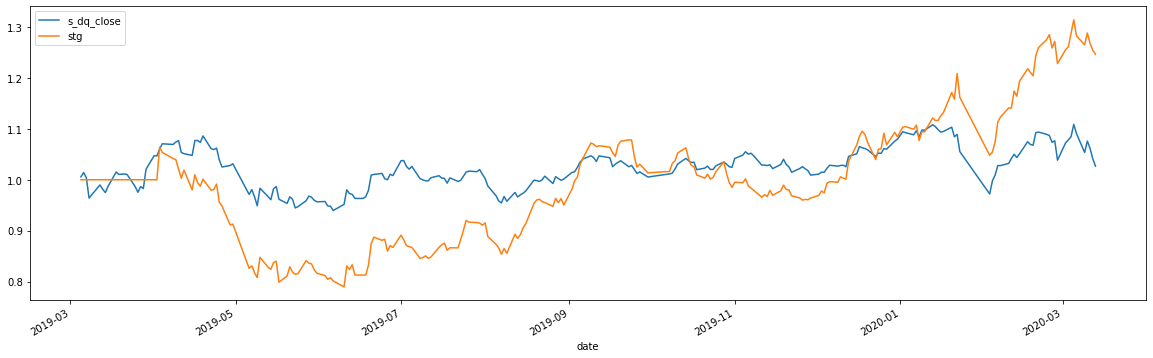

In [20]:
np.exp(np.log(equity_index).diff().cumsum()).plot(figsize=(20,6))

In [21]:
# 简单收益率
equity_index_ret=np.expm1(np.log(equity_index).diff()).iloc[1:,:]

In [22]:
# 用到的是简单收益率
_x=pd.DataFrame([
    rq.Risk(
        daily_returns=equity_index_ret.iloc[:,1],
        benchmark_daily_returns=equity_index_ret.iloc[:,0],
        risk_free_rate=1e-4,
    ).all(),
    rq.Risk(
        daily_returns=equity_index_ret.iloc[:,0],
        benchmark_daily_returns=equity_index_ret.iloc[:,0],
        risk_free_rate=1e-4,
    ).all(),
]).T


In [23]:
_x

,0,1
return,0.246570,0.026675
annual_return,0.247666,0.026783
benchmark_return,0.026675,0.026675
benchmark_annual_return,0.026783,0.026783
alpha,0.215016,0.000000
beta,1.054825,1.000000
sharpe,0.884825,0.230639
max_drawdown,0.257964,0.134915
volatility,0.019013,0.013477
annual_volatility,0.301828,0.213942


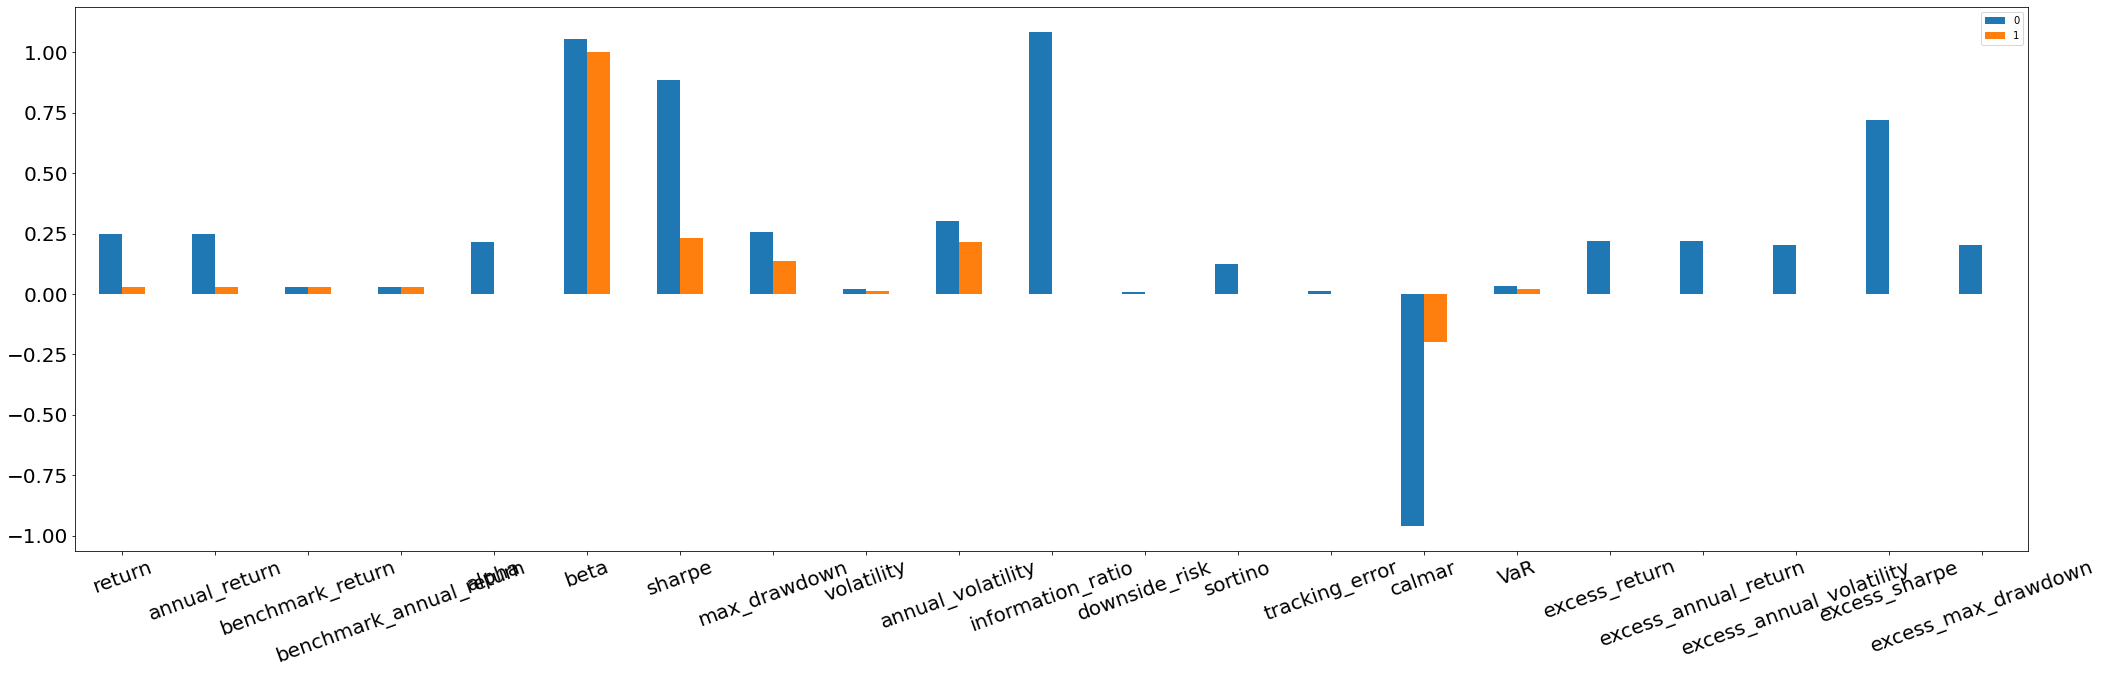

In [24]:
_x.plot.bar(figsize=(35,10))
plt.xticks(rotation=20)
plt.tick_params(labelsize=20)

# 策略优化

In [25]:
parameters=[(i,j) for i in range(15,21) for j in range(15,21)]# 参数组

In [26]:
def get_stg_ret(arg):
    stg=Strategy(*arg)
    app=xq.app.A0(stg=stg)
    _=list(app.route(x=i) for r in get_msg(prices,factors) for i in r)
    equity=pd.Series(data=stg.equity[:]+[app.a.equity])
    ret=np.expm1(np.log(equity).diff())
    return ret

In [27]:
%%time
ret_equity=pd.DataFrame({i:get_stg_ret(i) for i in parameters}).iloc[1:,:]

Wall time: 1min 50s


In [28]:
ret_equity.index=[i.strftime('%Y-%m-%d') for i in dates]

In [29]:
ret_index=np.expm1(np.log(h5['inx_close'].loc[:,['date','s_dq_close']].set_index('date')).diff())

In [30]:
ret=pd.concat(objs=(ret_index,ret_equity),axis=1,join='inner')
ret=ret.loc[ret.index>=factors.date.min(),:]
ret.shape

(252, 37)

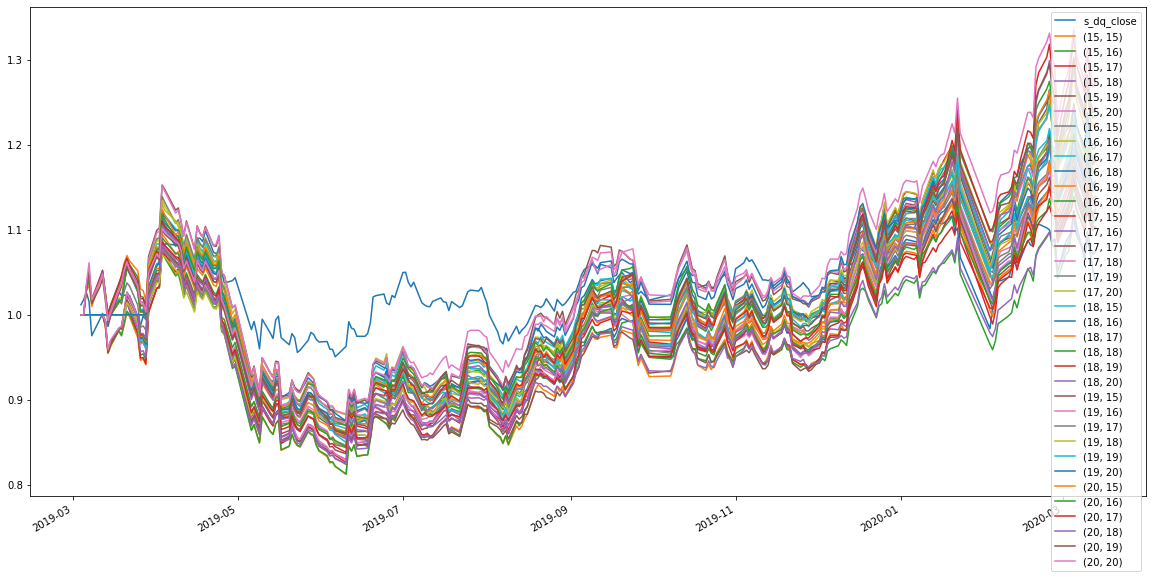

In [31]:
np.exp(np.log1p(ret).cumsum()).plot(figsize=(20,10))

In [32]:
pef=pd.DataFrame(
    data={i:rq.Risk(
        daily_returns=ret[i],
        benchmark_daily_returns=ret.iloc[:,0],
        risk_free_rate=1e-4,
    ).all() for i in ret.columns.to_list()[1:]}
).T

In [33]:
pef

return  annual_return  benchmark_return  benchmark_annual_return  \
15 15  0.120841       0.120841          0.038829                 0.038829   
   16  0.185146       0.185146          0.038829                 0.038829   
   17  0.181519       0.181519          0.038829                 0.038829   
   18  0.171083       0.171083          0.038829                 0.038829   
   19  0.154855       0.154855          0.038829                 0.038829   
   20  0.155112       0.155112          0.038829                 0.038829   
16 15  0.139178       0.139178          0.038829                 0.038829   
   16  0.187843       0.187843          0.038829                 0.038829   
   17  0.169632       0.169632          0.038829                 0.038829   
   18  0.124018       0.124018          0.038829                 0.038829   
   19  0.120204       0.120204          0.038829                 0.038829   
   20  0.074629       0.074629          0.038829                 0.038829   
17 15  0.100461       0.100461          0.038829                 0.038829   
   16  0.101199       0.101199          0.038829                 0.038829   
   17  0.112219       0.112219          0.038829                 0.038829   
   18  0.126369       0.126369          0.038829                 0.038829   
   19  0.164407       0.164407          0.038829                 0.038829   
   20  0.165070       0.165070          0.038829                 0.038829   
18 15  0.152206       0.152206          0.038829                 0.038829   
   16  0.157412       0.157412          0.038829                 0.038829   
   17  0.136392       0.136392          0.038829                 0.038829   
   18  0.114019       0.114019          0.038829                 0.038829   
   19  0.103141       0.103141          0.038829                 0.038829   
   20  0.073355       0.073355          0.038829                 0.038829   
19 15  0.197598       0.197598          0.038829                 0.038829   
   16  0.187950       0.187950          0.038829                 0.038829   
   17  0.149127       0.149127          0.038829                 0.038829   
   18  0.190279       0.190279          0.038829                 0.038829   
   19  0.185183       0.185183          0.038829                 0.038829   
   20  0.202545       0.202545          0.038829                 0.038829   
20 15  0.225737       0.225737          0.038829                 0.038829   
   16  0.234118       0.234118          0.038829                 0.038829   
   17  0.272356       0.272356          0.038829                 0.038829   
   18  0.240733       0.240733          0.038829                 0.038829   
   19  0.243309       0.243309          0.038829                 0.038829   
   20  0.278263       0.278263          0.038829                 0.038829   

          alpha      beta    sharpe  max_drawdown  volatility  \
15 15  0.088416  1.032371  0.555317      0.245389    0.017172   
   16  0.144642  1.017404  0.763007      0.243271    0.017064   
   17  0.141701  1.001888  0.757465      0.240360    0.016866   
   18  0.131914  0.979499  0.739836      0.232533    0.016318   
   19  0.118395  0.921677  0.707152      0.232717    0.015554   
   20  0.118237  0.936398  0.704188      0.228502    0.015686   
16 15  0.104766  1.011557  0.620024      0.228315    0.016912   
   16  0.146280  0.992312  0.786822      0.219098    0.016556   
   17  0.130721  1.001107  0.725153      0.220211    0.016659   
   18  0.090680  0.949909  0.590916      0.231382    0.015843   
   19  0.086481  0.925775  0.589935      0.222647    0.015263   
   20  0.044887  0.906632  0.422302      0.222050    0.014943   
17 15  0.070215  0.989164  0.495627      0.216526    0.016592   
   16  0.070303  0.987002  0.500449      0.222107    0.016426   
   17  0.079905  0.948856  0.550758      0.226118    0.015758   
   18  0.091982  0.932255  0.610365      0.213940    0.015361   
   19  0.124674  0.937434  0.747944      0.214554    0

In [34]:
x=pef['annual_return']

In [35]:
X,Y=np.meshgrid(x.index.levels[0],x.index.levels[1])

In [36]:
r0=[]
for i in range(X.shape[0]):
    r1=[]
    for j in range(X.shape[1]):
        r1.append(x[(X[i,j],Y[i,j])])
    r0.append(r1)

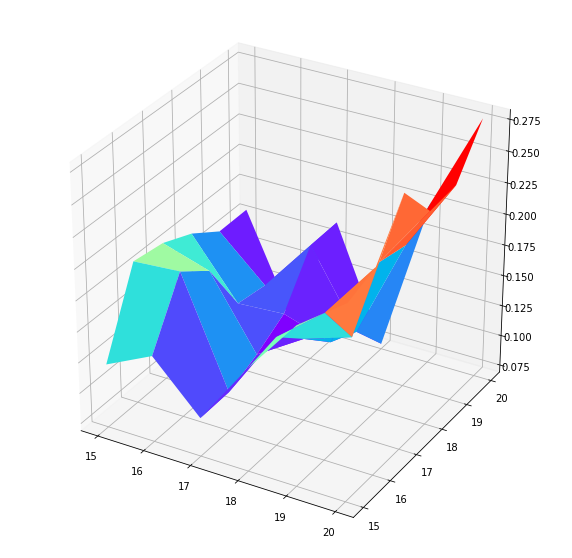

In [37]:
plt.figure(figsize=(10,10))
ax3=plt.axes(projection='3d')
ax3.plot_surface(X,Y,np.array(r0),cmap='rainbow')